# Land Type Classification using Sentinel-2 Satellite Images

#### This project focuses on leveraging Deep Neural Networks (DNNs) to classify different land types (such as agriculture, water, urban areas, desert, roads, and trees).

## Step 1: Data Collection:

#### EuroSAT is a well-known dataset of Sentinel-2 satellite images designed for land use and land cover classification.
Download dataset [EuroSAT Dataset (RGB)](https://madm.dfki.de/files/sentinel/EuroSAT.zip)

#### Path to the dataset: 'EuroSAT/2750/' with 10 subfolders each containing around 2000-3000 images.

## Step 2: Data Exploration:

In [7]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
import cv2
from collections import Counter

In [8]:
# Define dataset path
dataset_path = "EuroSAT/"

In [9]:
# List all land type categories
categories = os.listdir(dataset_path)

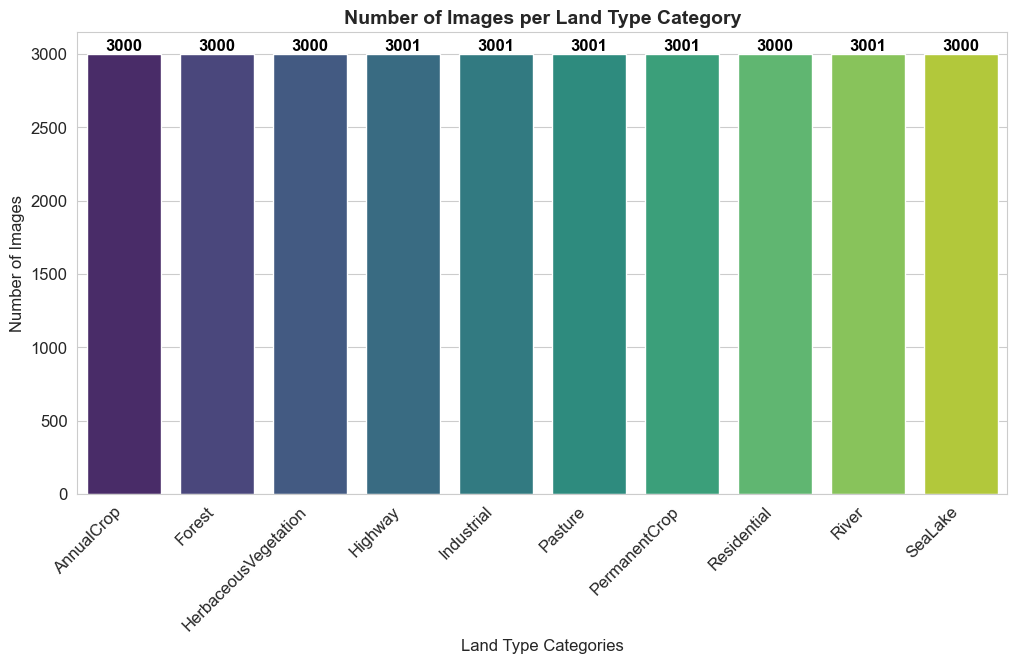

In [10]:
# Count the number of images per category
image_count = {}
for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_count[category] = len(os.listdir(category_path))

# Set Seaborn style
sns.set_style("whitegrid")

# Create the bar plot (fix: assign `x` to `hue` and disable legend)
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=list(image_count.keys()), y=list(image_count.values()), hue=list(image_count.keys()), palette="viridis", legend=False)

# Add exact counts on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Improve readability
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.title('Number of Images per Land Type Category', fontsize=14, fontweight='bold')
plt.xlabel('Land Type Categories', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)

# Show the plot
plt.show()

In [11]:
# List all land type categories
categories = os.listdir(dataset_path)

# Count the number of images per category (excluding directories)
image_count = {}

for category in categories:
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):  # Ensure it's a folder
        num_images = len([f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        image_count[category] = num_images

# Display the image count per class
print("Before Augmentation:")
for category, count in image_count.items():
    print(f"Class: {category} -> {count} images")

Before Augmentation:
Class: AnnualCrop -> 3000 images
Class: Forest -> 3000 images
Class: HerbaceousVegetation -> 3000 images
Class: Highway -> 3000 images
Class: Industrial -> 3000 images
Class: Pasture -> 3000 images
Class: PermanentCrop -> 3000 images
Class: Residential -> 3000 images
Class: River -> 3000 images
Class: SeaLake -> 3000 images


In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

# Define target number of images per class (match the max class count, which is 3000)
target_images_per_class = 3000

# Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to generate augmented images
def augment_and_save_images(class_name, num_to_generate):
    class_path = os.path.join(dataset_path, class_name)
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not images:
        print(f"No images found in {class_name}, skipping augmentation.")
        return

    i = 0
    while num_to_generate > 0:
        img_name = images[i % len(images)]  # Cycle through existing images
        img_path = os.path.join(class_path, img_name)

        img = tf.keras.preprocessing.image.load_img(img_path)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = img_array.reshape((1,) + img_array.shape)

        save_prefix = f"aug_{i}_"
        save_path = os.path.join(class_path, save_prefix + img_name)
        
        # Generate one new image at a time
        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=class_path, save_prefix=save_prefix, save_format="png"):
            num_to_generate -= 1
            i += 1
            break  # Only generate one image per iteration to avoid unnecessary loops

# Identify classes that need augmentation
classes_to_augment = {cls: target_images_per_class - count for cls, count in image_count.items() if count < target_images_per_class}

# Apply augmentation for each class
for class_name, num_images in classes_to_augment.items():
    print(f"Augmenting {class_name} with {num_images} new images...")
    augment_and_save_images(class_name, num_images)

print("Augmentation complete!")


Augmentation complete!


In [13]:
# Recalculate image counts after augmentation
image_count_after = {}

for category in categories:
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        num_images = len([f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        image_count_after[category] = num_images

# Display updated counts
print("\nAfter Augmentation:")
for category, count in image_count_after.items():
    print(f"Class: {category} -> {count} images")



After Augmentation:
Class: AnnualCrop -> 3000 images
Class: Forest -> 3000 images
Class: HerbaceousVegetation -> 3000 images
Class: Highway -> 3000 images
Class: Industrial -> 3000 images
Class: Pasture -> 3000 images
Class: PermanentCrop -> 3000 images
Class: Residential -> 3000 images
Class: River -> 3000 images
Class: SeaLake -> 3000 images


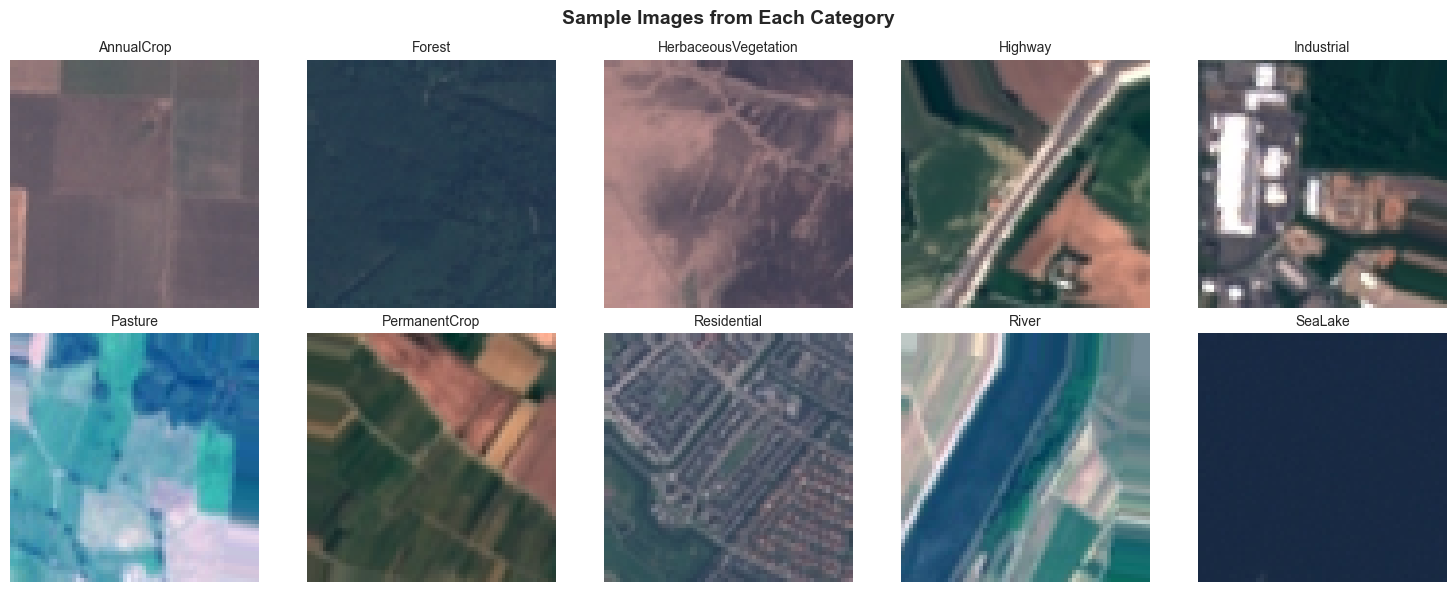

In [14]:
categories = sorted(os.listdir(dataset_path))  # Sort for consistent ordering

# Adjust figure size dynamically based on the number of categories
num_classes = len(categories)
cols = 5  # Define the number of columns
rows = (num_classes // cols) + (num_classes % cols > 0)  # Compute rows dynamically

plt.figure(figsize=(15, rows * 3))

for i, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    
    # Ensure category has images
    images = [img for img in os.listdir(category_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not images:
        continue  # Skip empty folders

    sample_image = images[0]  # Pick the first available image
    img = Image.open(os.path.join(category_path, sample_image))

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(category, fontsize=10)
    plt.axis('off')

plt.suptitle('Sample Images from Each Category', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [15]:
def check_images(dataset_path):
    corrupted = []
    categories = sorted(os.listdir(dataset_path))

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        
        # Ensure it's a directory
        if not os.path.isdir(category_path):
            continue
        
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)

            # Skip if it's a directory
            if os.path.isdir(img_path):
                continue

            # Check only image files
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Verify if the image is readable
            except Exception as e:
                corrupted.append((category, img_name))

    return corrupted

In [16]:
corrupted_images = check_images(dataset_path)

# Print final results
print(f"Number of corrupted images: {len(corrupted_images)}")
if corrupted_images:
    print("Corrupted images:", corrupted_images)
else:
    print("No corrupted images found! ✅")

Number of corrupted images: 0
No corrupted images found! ✅


In [17]:
import cv2
from collections import Counter

def analyze_image_sizes(dataset_path):
    image_shapes = []

    # Iterate through each category
    for category in sorted(os.listdir(dataset_path)):
        category_path = os.path.join(dataset_path, category)
        
        if not os.path.isdir(category_path):  # Skip non-folder files
            continue
        
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            
            # Ensure it's an image file
            if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
            
            img = cv2.imread(img_path)
            if img is not None:
                image_shapes.append(img.shape)

    return Counter(image_shapes)

# Run the function
image_dimensions = analyze_image_sizes(dataset_path)

# Print result
print("Image Dimensions (All Images):", image_dimensions)


Image Dimensions (All Images): Counter({(64, 64, 3): 30000})


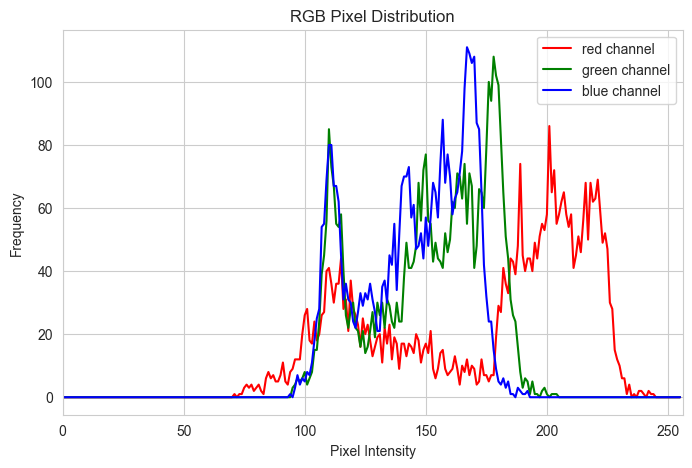

In [18]:
# Visualize RGB histograms for sample image

import random

def plot_pixel_distribution(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    colors = ("red", "green", "blue")
    plt.figure(figsize=(8, 5))

    for i, color in enumerate(colors):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        plt.plot(hist, color=color, label=f"{color} channel")
        plt.xlim([0, 256])

    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("RGB Pixel Distribution")
    plt.show()

# Test with one random image
random_img_path = os.path.join(dataset_path, "AnnualCrop", random.choice(os.listdir(os.path.join(dataset_path, "AnnualCrop"))))
plot_pixel_distribution(random_img_path)

#### Key Observations:
- The **blue** channel has a strong peak around 100, meaning the image has a **dominant blue tone**.
- The **green** channel has a peak around 90-110, suggesting a **significant presence of green shades**.
- The **red** channel has multiple smaller peaks spread across 50-150, indicating that **red** tones are **distributed more variably**.
- There are almost no pixels beyond **200** intensity, meaning the image does not have pure **white** or very bright areas.

In [19]:
import cv2
import pandas as pd
from scipy.stats import skew

def get_dataset_rgb_statistics(dataset_path, categories):
    dataset_stats = {"red": [], "green": [], "blue": []}

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)

            if img is not None:  # Ensure the image is readable
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                for i, color in enumerate(["red", "green", "blue"]):
                    channel = img[:, :, i].flatten()
                    dataset_stats[color].append({
                        "Mean": np.mean(channel),
                        "Std Dev": np.std(channel),
                        "Min": np.min(channel),
                        "Max": np.max(channel),
                        "Skewness": skew(channel)
                    })

    # Convert to DataFrame
    stats_df = {}
    for color in ["red", "green", "blue"]:
        stats_df[color] = pd.DataFrame(dataset_stats[color]).mean()

    return pd.DataFrame(stats_df).T  # Transpose for readability

# Run analysis
dataset_rgb_stats = get_dataset_rgb_statistics(dataset_path, categories)
print(dataset_rgb_stats)


             Mean    Std Dev        Min         Max  Skewness
red     86.346057  25.166285  40.286533  180.860867  1.019751
green   97.905314  17.947182  62.701467  176.751933  0.936004
blue   105.483281  15.125636  76.994933  177.726833  1.182729


## Interpretation
- **Mean Values:** The blue channel has the highest mean intensity, followed by green and red.
- **Standard Deviation:** The red channel exhibits the highest variability, indicating a wider range of intensities.
- **Skewness:** Positive skewness across all channels suggests a concentration of pixel values in the lower range with a longer tail towards higher intensities.

This analysis provides insights into the dataset's color composition, which can be useful for preprocessing and model training.

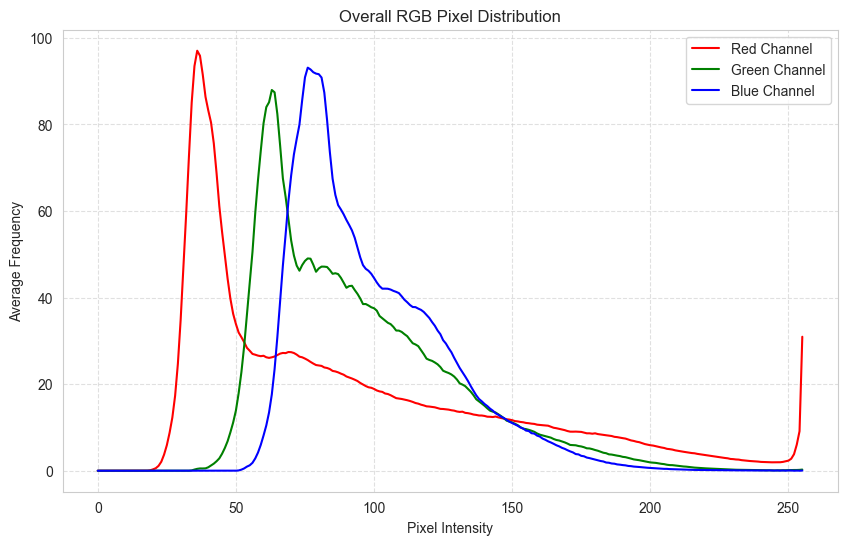

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_pixel_distribution(dataset_path, categories):
    total_hist_r = np.zeros(256)
    total_hist_g = np.zeros(256)
    total_hist_b = np.zeros(256)
    total_images = 0

    if not os.path.exists(dataset_path):
        print(f"Error: Dataset path '{dataset_path}' does not exist.")
        return

    for category in categories:
        class_folder = os.path.join(dataset_path, category)
        
        if not os.path.exists(class_folder):
            print(f"Warning: {class_folder} does not exist. Skipping...")
            continue

        image_files = [f for f in os.listdir(class_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if not image_files:
            print(f"Warning: No images found in {class_folder}. Skipping...")
            continue

        for img_name in image_files:
            img_path = os.path.join(class_folder, img_name)
            img = cv2.imread(img_path)

            if img is None:
                print(f"Skipping unreadable image: {img_path}")
                continue
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            hist_r = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()
            hist_g = cv2.calcHist([img], [1], None, [256], [0, 256]).flatten()
            hist_b = cv2.calcHist([img], [2], None, [256], [0, 256]).flatten()
            
            total_hist_r += hist_r
            total_hist_g += hist_g
            total_hist_b += hist_b
            total_images += 1

    if total_images == 0:
        print("No valid images found. Exiting...")
        return
    
    # Normalize histograms
    total_hist_r /= total_images
    total_hist_g /= total_images
    total_hist_b /= total_images

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(total_hist_r, color="red", label="Red Channel")
    plt.plot(total_hist_g, color="green", label="Green Channel")
    plt.plot(total_hist_b, color="blue", label="Blue Channel")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Average Frequency")
    plt.legend()
    plt.title("Overall RGB Pixel Distribution")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Example Usage
dataset_path = "EuroSAT/"
categories = ["AnnualCrop", "Forest", "HerbaceousVegetation"]  
compute_pixel_distribution(dataset_path, categories)


## 📊 Understanding the RGB Pixel Distribution Graph

### **Graph Explanation**
- **X-axis**: Represents **pixel intensity values** (0-255), where:
  - `0` → **Black** (lowest intensity)
  - `255` → **White** (highest intensity)
- **Y-axis**: Represents the **average frequency** of each intensity across all images.
- **Curves Represent Different Channels:**
  - 🔴 **Red Channel**
  - 🟢 **Green Channel**
  - 🔵 **Blue Channel**

### **📌 Key Insights from the Graph**
1. **Blue Dominance Around 80-100 Intensity**  
   - The blue curve has the highest peak around **80-100**.
   - This suggests that many images in the dataset contain **blueish tones** (e.g., water bodies, sky, or shadows).

2. **Green and Red Are More Spread Out**  
   - The **green curve** peaks between **50-100**, indicating the presence of **vegetation or natural elements**.
   - The **red curve** is more distributed, with peaks around **40-60**, suggesting the presence of **soil, buildings, or reddish tones**.

3. **Low Intensities (Shadows/Dark Areas)**  
   - The left side of the graph (0-50) shows noticeable activity in **red and green**, meaning some images have **dark or shadowed areas**.

4. **High Intensities (Bright Areas)**  
   - The right side of the graph (200-255) has lower values, meaning fewer **very bright areas** exist in the dataset.

## Step 3: Data Preprocessing:

In [21]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [22]:
# Define transformation (without normalization)
transform = transforms.Compose([
    transforms.ToTensor()  # Convert images to tensors
])

In [23]:
# Load dataset
dataset = ImageFolder(root=dataset_path, transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

In [24]:
# Compute mean and std
mean = torch.zeros(3)
std = torch.zeros(3)
num_samples = 0

for images, _ in loader:
    batch_samples = images.size(0)  # Batch size
    images = images.view(batch_samples, 3, -1)  # Flatten image pixels
    mean += images.mean(dim=[0, 2])  # Compute mean per channel
    std += images.std(dim=[0, 2])  # Compute std per channel
    num_samples += batch_samples

mean /= num_samples
std /= num_samples

print(f"Dataset Mean: {mean.tolist()}")
print(f"Dataset Std: {std.tolist()}")

Dataset Mean: [0.00512995570898056, 0.00617502024397254, 0.006702838931232691]
Dataset Std: [0.002528515411540866, 0.0019256382947787642, 0.0017749716062098742]


In [25]:
# Define preprocessing transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15, interpolation=transforms.InterpolationMode.BICUBIC, fill=128),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

# transforms.Grayscale(num_output_channels=1),  # we not Convert to grayscaleabs
# Keep RGB because color carries meaningful features.

# transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # well crop alot of details from images

# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.0054, 0.0059, 0.0064], std=[0.0023, 0.0017, 0.0014])  # Use computed values
# ])

#### Why These Specific Transformations?
Data augmentation helps improve model generalization by introducing variations in the training data. Here’s why each transformation is useful:

- **`transforms.RandomHorizontalFlip(p=0.5)`**  
  - Flips the image horizontally with a 50% chance.  
  - Useful for datasets where objects can appear in either left or right orientations.  

- **`transforms.RandomVerticalFlip(p=0.5)`**  
  - Flips the image vertically with a 50% chance.  
  - Helpful for satellite or aerial images where features might not have a fixed orientation.  

- **`transforms.RandomRotation(15)`**  
  - Rotates the image randomly by up to ±15 degrees.  
  - Helps the model learn rotation-invariant features, useful for real-world scenarios where objects might not always be perfectly aligned.  

- **`transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)`**  
  - Randomly adjusts brightness, contrast, saturation, and hue.  
  - Improves robustness to lighting variations and different weather conditions, making the model more adaptable to real-world images.  

These transformations enhance the diversity of the training data, reducing overfitting and improving the model’s performance. 🚀

- **`ToTensor()`** → Converts image to PyTorch tensor format.
- **`Normalize(mean, std)`** → Uses your dataset-specific values to improve model convergence and stability.

In [26]:
# Load Dataset with Transformations
dataset = ImageFolder(root=dataset_path, transform=transform)

In [27]:
# Split the Dataset
train_size = int(0.7 * len(dataset))  # 70% Training
val_size = int(0.2 * len(dataset))    # 20% Validation
test_size = len(dataset) - train_size - val_size  # 10% Test

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [28]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

Train size: 26119, Validation size: 7462, Test size: 3732


#### Visualizing Augmented Images
Since we've applied transformations (flipping, rotation, color jitter), it's essential to visualize the modified images to ensure they're applied correctly.

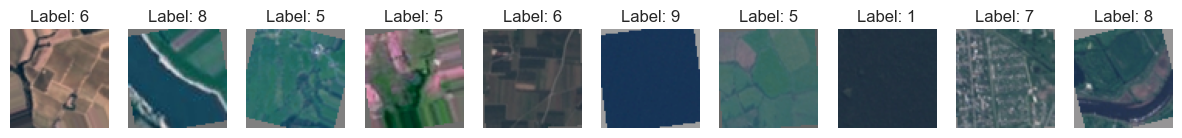

In [29]:
# Function to Display Sample Images from Dataset
def show_images(dataset, mean, std, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    # Convert mean and std lists to NumPy arrays for element-wise operations
    mean = np.array(mean.tolist())  # Use mean.tolist() dynamically
    std = np.array(std.tolist())    # Use std.tolist() dynamically

    for i in range(num_images):
        img, label = dataset[i]
        img = img.numpy().transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)

        # Reverse normalization (denormalize)
        img = img * std + mean
        img = np.clip(img, 0, 1)  # Keep pixel values in valid range

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")
    plt.subplots_adjust(wspace=0.2)  # Increase spacing between images

    plt.show()

# Call function with dynamically computed mean & std
show_images(train_dataset, mean, std)

#### Class Distribution Visualization (After Preprocessing)

C:\Users\DELL\AppData\Local\Temp\ipykernel_13668\886665309.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Class Labels", y="Count", data=df, palette="Blues_r")  # Use a better color palette


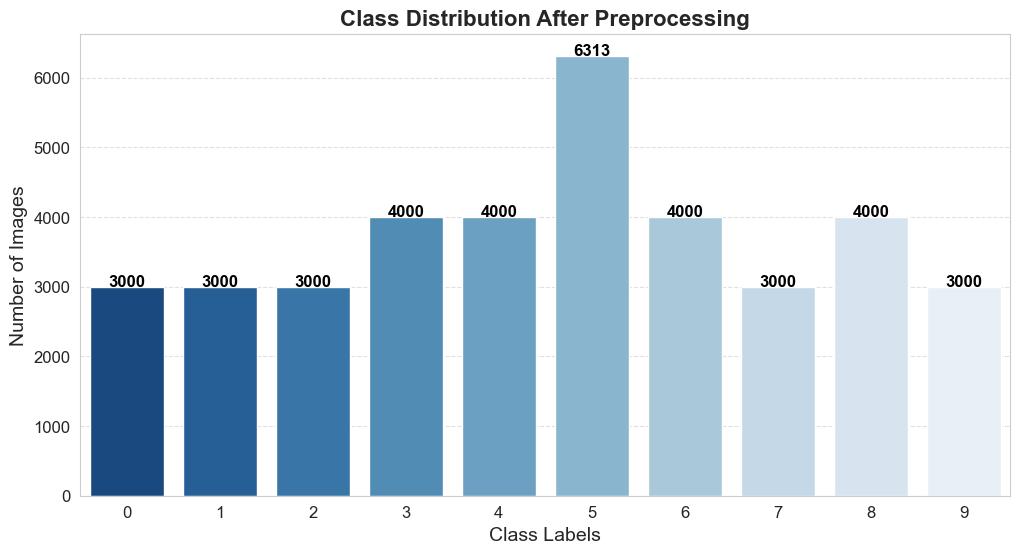

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Extract class labels
labels = [label for _, label in dataset]  
label_counts = Counter(labels)

# Convert to a DataFrame for Seaborn
df = pd.DataFrame({"Class Labels": list(label_counts.keys()), "Count": list(label_counts.values())})

# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="Class Labels", y="Count", data=df, palette="Blues_r")  # Use a better color palette

# Add labels & title
plt.xlabel("Class Labels", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.title("Class Distribution After Preprocessing", fontsize=16, fontweight="bold")

# Show counts on top of bars
for i, count in enumerate(df["Count"]):
    plt.text(i, count + 5, str(count), ha="center", fontsize=12, fontweight="bold", color="black")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()


In [31]:
labels = [label for _, label in dataset]  
label_counts = Counter(labels)

# Convert to a pandas DataFrame
df = pd.DataFrame({"Class Label": list(label_counts.keys()), "Count": list(label_counts.values())})

# Display the DataFrame
print(df)

   Class Label  Count
0            0   3000
1            1   3000
2            2   3000
3            3   4000
4            4   4000
5            5   6313
6            6   4000
7            7   3000
8            8   4000
9            9   3000


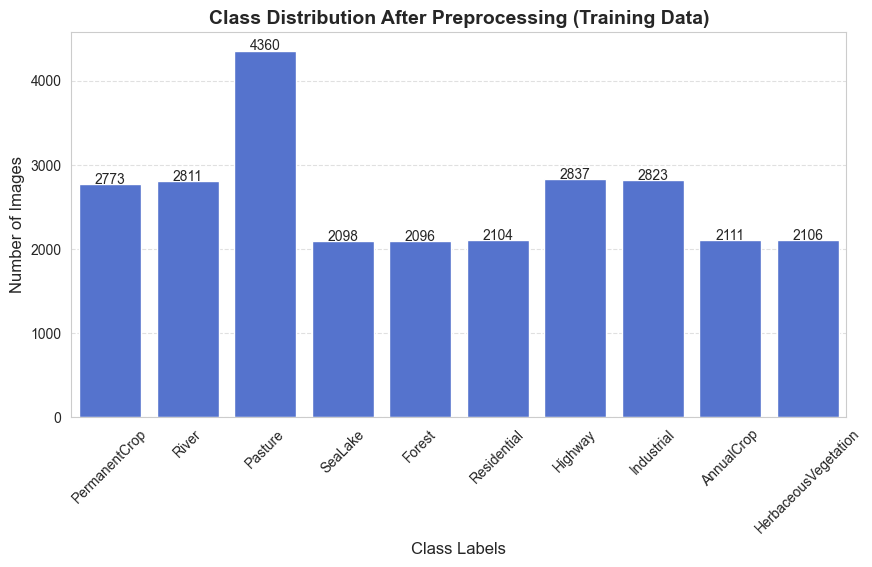

In [32]:
# Extract class labels from the train dataset
labels = [train_dataset.dataset.targets[i] for i in train_dataset.indices]
label_counts = Counter(labels)

# Convert to list format for seaborn
class_labels = [dataset.classes[i] for i in label_counts.keys()]
counts = list(label_counts.values())

# Plot using Seaborn
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=class_labels, y=counts, color="royalblue")

# Add labels & title
plt.xlabel("Class Labels", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Class Distribution After Preprocessing (Training Data)", fontsize=14, fontweight="bold")

# Show counts on top of bars
for i, count in enumerate(counts):
    ax.text(i, count + 2, str(count), ha="center", fontsize=10)

plt.xticks(rotation=45, fontsize=10)  # Rotate labels for better visibility
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()

In [40]:
labels = [train_dataset.dataset.targets[i] for i in train_dataset.indices]
label_counts = Counter(labels)

# Convert to a DataFrame
df = pd.DataFrame({"Class Label": list(label_counts.keys()), "Count": list(label_counts.values())})

# Display the DataFrame
print(df)

   Class Label  Count
0            6   2773
1            8   2811
2            5   4360
3            9   2098
4            1   2096
5            7   2104
6            3   2837
7            4   2823
8            0   2111
9            2   2106


#### PCA & t-SNE for Feature Visualization
Dimensionality reduction techniques like t-SNE or PCA can visualize image clusters.

#### Benefits of Using PCA & t-SNE in EDA
- **Feature Understanding**:
  - Helps inspect how well the dataset is structured.
  - Identifies similarities and differences between images.
- **Class Distribution & Clustering**:
  - Shows whether different classes form distinct clusters.
  - Detects overlapping or misclassified classes.
- **Detecting Anomalies**:
  - Helps spot outliers in the dataset.
  - Unusual points may indicate data quality issues.
- **Model Selection Insight**:
  - If classes are well-separated, a simple classifier like Logistic Regression might work.
  - If classes overlap, a deep learning model may be needed.

In [33]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [34]:
# Function to extract image features from the dataset
def extract_features(dataloader):
    features = []
    labels = []
    
    for images, lbls in dataloader:
        images = images.view(images.size(0), -1)  # Flatten images
        features.append(images.numpy())
        labels.extend(lbls.numpy())
    
    return np.vstack(features), np.array(labels)

In [35]:
# Extract features from training set
features, labels = extract_features(train_loader)

In [36]:
# Apply PCA (reduce to 2 components for visualization)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

In [37]:
# Apply t-SNE (reduce to 2 components for visualization)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_features = tsne.fit_transform(features)

Text(0, 0.5, 'Principal Component 2')

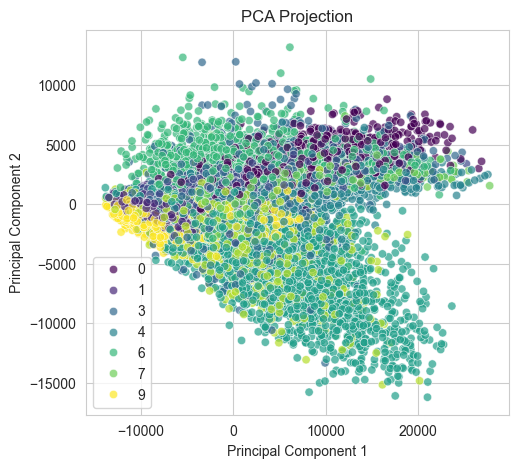

In [38]:
# Plot PCA
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

Text(0, 0.5, 't-SNE Component 2')

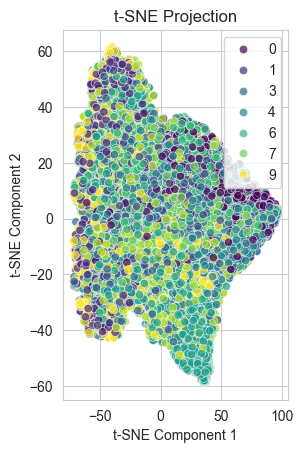

In [39]:
# Plot t-SNE
plt.subplot(1, 2, 2)
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("t-SNE Projection")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

#### Conclusion:
- High overlap in PCA & t-SNE means the dataset does not have well-separated clusters **(not linearly separable)**.
  - This suggests that images from different classes look somewhat similar in feature space.
  - Simple classifiers like logistic regression or linear SVM may struggle.
- t-SNE improves local clustering slightly, but classes are still mixed.
  - This tells us that even with a non-linear method, the data does not have naturally distinct groups.

#### We might need better feature extraction (e.g., CNN embeddings) to extract better features before classification to classify the data well.

## Step 4: Modelling:

In [48]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
import tensorflow as tf

# Define input shape
input_layer = Input(shape=(64, 64, 3))

# First Conv Block
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

# Second Conv Block
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

# Third Conv Block
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

# Fourth Conv Block
x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

# Flatten and Fully Connected Layer
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(10, activation='softmax')(x)  # 10 classes

# Create the Model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,493,130 (9.51 MB)

 Trainable params: 2,492,170 (9.51 MB)

 Non-trainable params: 960 (3.75 KB)

In [53]:
import torchvision.transforms as transforms

# Define Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Ensure all images are 64x64
    transforms.ToTensor(),  # Convert images to tensors (scales to [0,1])
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1,1]
])

# Apply transform to dataset
train_dataset.transform = transform
val_dataset.transform = transform
test_dataset.transform = transform


In [54]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),  # Adjust based on input size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = CNN(num_classes=10)


In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [56]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")


Epoch [1/10], Loss: 1.3294, Accuracy: 52.44%
Epoch [2/10], Loss: 0.9457, Accuracy: 65.88%
Epoch [3/10], Loss: 0.8227, Accuracy: 71.07%
Epoch [4/10], Loss: 0.7248, Accuracy: 74.59%
Epoch [5/10], Loss: 0.6740, Accuracy: 76.42%
Epoch [6/10], Loss: 0.6023, Accuracy: 79.38%
Epoch [7/10], Loss: 0.5624, Accuracy: 81.08%
Epoch [8/10], Loss: 0.5092, Accuracy: 83.07%
Epoch [9/10], Loss: 0.4606, Accuracy: 84.36%
Epoch [10/10], Loss: 0.4334, Accuracy: 85.74%


In [57]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_acc = 100 * correct / total
print(f"Validation Accuracy: {val_acc:.2f}%")


Validation Accuracy: 83.32%


## Using RestNet

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from torchvision import models
from torch.utils.data import DataLoader
from tqdm import tqdm

# Custom ResNet Model
class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        self.resnet = models.resnet18(weights=None)  
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Adjust for 64x64 input
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)  # 10 classes

    def forward(self, x):
        return self.resnet(x)

# Define hyperparameter search space
param_grid = {
    "learning_rate": [0.001, 0.0005, 0.0001],
    "batch_size": [16, 32, 64],
    "optimizer": ["adam", "sgd"],
    "epochs": [5, 10, 15]
}

# Function to train and evaluate a model with given hyperparameters
def train_and_evaluate(params, train_loader, val_loader):
    model = CustomResNet(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()

    if params["optimizer"] == "adam":
        optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"])
    else:
        optimizer = optim.SGD(model.parameters(), lr=params["learning_rate"], momentum=0.9)

    best_acc = 0.0  # Track best validation accuracy

    for epoch in range(params["epochs"]):
        model.train()
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{params['epochs']}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = 100 * correct / total
        print(f"Validation Accuracy: {accuracy:.2f}%")

        if accuracy > best_acc:
            best_acc = accuracy
            best_model = model.state_dict()

    return best_acc, best_model

# Run Random Search
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_hyperparams = None
best_model_state = None
highest_acc = 0.0

for i in range(5):  # Run 5 random experiments
    random_params = {k: random.choice(v) for k, v in param_grid.items()}
    print(f"\nTrial {i+1}: {random_params}")

    # Define DataLoaders with chosen batch size
    train_loader = DataLoader(train_dataset, batch_size=random_params["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=random_params["batch_size"], shuffle=False)

    acc, model_state = train_and_evaluate(random_params, train_loader, val_loader)

    if acc > highest_acc:
        highest_acc = acc
        best_hyperparams = random_params
        best_model_state = model_state

# Save best model
torch.save(best_model_state, "best_resnet_model.pth")
print(f"\nBest Hyperparameters: {best_hyperparams}")
print(f"Highest Validation Accuracy: {highest_acc:.2f}%")



Trial 1: {'learning_rate': 0.0001, 'batch_size': 16, 'optimizer': 'adam', 'epochs': 15}


Epoch 1/15: 100%|██████████| 1633/1633 [10:18<00:00,  2.64it/s]


Validation Accuracy: 72.69%


Epoch 2/15: 100%|██████████| 1633/1633 [09:58<00:00,  2.73it/s]


Validation Accuracy: 82.11%


Epoch 3/15: 100%|██████████| 1633/1633 [10:21<00:00,  2.63it/s]


Validation Accuracy: 85.89%


Epoch 4/15: 100%|██████████| 1633/1633 [22:02<00:00,  1.23it/s]    


Validation Accuracy: 88.50%


Epoch 5/15: 100%|██████████| 1633/1633 [10:00<00:00,  2.72it/s]


Validation Accuracy: 89.63%


Epoch 6/15: 100%|██████████| 1633/1633 [10:57<00:00,  2.48it/s]


Validation Accuracy: 90.89%


Epoch 7/15: 100%|██████████| 1633/1633 [10:28<00:00,  2.60it/s]


Validation Accuracy: 91.66%


Epoch 8/15: 100%|██████████| 1633/1633 [10:23<00:00,  2.62it/s]


Validation Accuracy: 92.83%


Epoch 9/15: 100%|██████████| 1633/1633 [10:21<00:00,  2.63it/s]


Validation Accuracy: 91.68%


Epoch 10/15: 100%|██████████| 1633/1633 [10:27<00:00,  2.60it/s]


Validation Accuracy: 92.60%


Epoch 11/15: 100%|██████████| 1633/1633 [10:24<00:00,  2.61it/s]


Validation Accuracy: 92.70%


Epoch 12/15: 100%|██████████| 1633/1633 [10:25<00:00,  2.61it/s]


Validation Accuracy: 92.92%


Epoch 13/15: 100%|██████████| 1633/1633 [10:23<00:00,  2.62it/s]


Validation Accuracy: 93.29%


Epoch 14/15: 100%|██████████| 1633/1633 [10:24<00:00,  2.62it/s]


Validation Accuracy: 93.47%


Epoch 15/15: 100%|██████████| 1633/1633 [10:23<00:00,  2.62it/s]


Validation Accuracy: 92.79%

Trial 2: {'learning_rate': 0.0005, 'batch_size': 16, 'optimizer': 'sgd', 'epochs': 5}


Epoch 1/5: 100%|██████████| 1633/1633 [10:01<00:00,  2.71it/s]


Validation Accuracy: 63.60%


Epoch 2/5: 100%|██████████| 1633/1633 [09:00<00:00,  3.02it/s]


Validation Accuracy: 52.10%


Epoch 3/5: 100%|██████████| 1633/1633 [09:31<00:00,  2.86it/s]


Validation Accuracy: 74.18%


Epoch 4/5: 100%|██████████| 1633/1633 [10:17<00:00,  2.64it/s]


Validation Accuracy: 82.07%


Epoch 5/5: 100%|██████████| 1633/1633 [10:31<00:00,  2.58it/s]


Validation Accuracy: 83.37%

Trial 3: {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'sgd', 'epochs': 5}


Epoch 1/5: 100%|██████████| 817/817 [09:18<00:00,  1.46it/s]


Validation Accuracy: 59.65%


Epoch 2/5: 100%|██████████| 817/817 [08:51<00:00,  1.54it/s]


Validation Accuracy: 64.84%


Epoch 3/5: 100%|██████████| 817/817 [08:50<00:00,  1.54it/s]


Validation Accuracy: 69.90%


Epoch 4/5: 100%|██████████| 817/817 [08:50<00:00,  1.54it/s]


Validation Accuracy: 79.83%


Epoch 5/5: 100%|██████████| 817/817 [08:52<00:00,  1.53it/s]


Validation Accuracy: 69.51%

Trial 4: {'learning_rate': 0.0001, 'batch_size': 64, 'optimizer': 'sgd', 'epochs': 10}


Epoch 1/10: 100%|██████████| 409/409 [08:47<00:00,  1.29s/it]


Validation Accuracy: 42.70%


Epoch 2/10: 100%|██████████| 409/409 [08:44<00:00,  1.28s/it]


Validation Accuracy: 52.51%


Epoch 3/10: 100%|██████████| 409/409 [08:42<00:00,  1.28s/it]


Validation Accuracy: 58.27%


Epoch 4/10: 100%|██████████| 409/409 [08:45<00:00,  1.28s/it]


Validation Accuracy: 58.90%


Epoch 5/10: 100%|██████████| 409/409 [08:46<00:00,  1.29s/it]


Validation Accuracy: 65.64%


Epoch 6/10: 100%|██████████| 409/409 [08:47<00:00,  1.29s/it]


Validation Accuracy: 55.01%


Epoch 7/10: 100%|██████████| 409/409 [09:04<00:00,  1.33s/it]


Validation Accuracy: 53.36%


Epoch 8/10: 100%|██████████| 409/409 [08:52<00:00,  1.30s/it]


Validation Accuracy: 63.50%


Epoch 9/10: 100%|██████████| 409/409 [09:03<00:00,  1.33s/it]


Validation Accuracy: 69.54%


Epoch 10/10: 100%|██████████| 409/409 [09:05<00:00,  1.33s/it]


Validation Accuracy: 66.83%

Trial 5: {'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'adam', 'epochs': 5}


Epoch 1/5: 100%|██████████| 409/409 [09:17<00:00,  1.36s/it]


Validation Accuracy: 70.34%


Epoch 2/5: 100%|██████████| 409/409 [09:20<00:00,  1.37s/it]


Validation Accuracy: 67.60%


Epoch 3/5: 100%|██████████| 409/409 [09:26<00:00,  1.39s/it]


Validation Accuracy: 80.41%


Epoch 4/5: 100%|██████████| 409/409 [09:27<00:00,  1.39s/it]


Validation Accuracy: 81.98%


Epoch 5/5: 100%|██████████| 409/409 [09:04<00:00,  1.33s/it]


Validation Accuracy: 88.80%

Best Hyperparameters: {'learning_rate': 0.0001, 'batch_size': 16, 'optimizer': 'adam', 'epochs': 15}
Highest Validation Accuracy: 93.47%


In [60]:
best_model = CustomResNet(num_classes=10).to(device)
best_model.load_state_dict(torch.load("best_resnet_model.pth"))
best_model.eval()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Final Test Accuracy: {100 * correct / total:.2f}%")


Final Test Accuracy: 91.85%


In [61]:
# Load the best model
model = CustomResNet(num_classes=10).to(device)
model.load_state_dict(torch.load("best_resnet_model.pth"))
model.eval()

# Evaluate on test set
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 92.10%



Classification Report:
              precision    recall  f1-score   support

           0     0.9148    0.9265    0.9206       313
           1     0.9601    0.9570    0.9585       302
           2     0.7727    0.8889    0.8267       306
           3     0.9465    0.8984    0.9218       374
           4     0.9569    0.9753    0.9660       364
           5     0.9261    0.9573    0.9414       655
           6     0.9077    0.8536    0.8798       403
           7     0.9888    0.8360    0.9060       317
           8     0.9265    0.9333    0.9299       405
           9     0.9539    0.9898    0.9715       293

    accuracy                         0.9234      3732
   macro avg     0.9254    0.9216    0.9222      3732
weighted avg     0.9259    0.9234    0.9235      3732



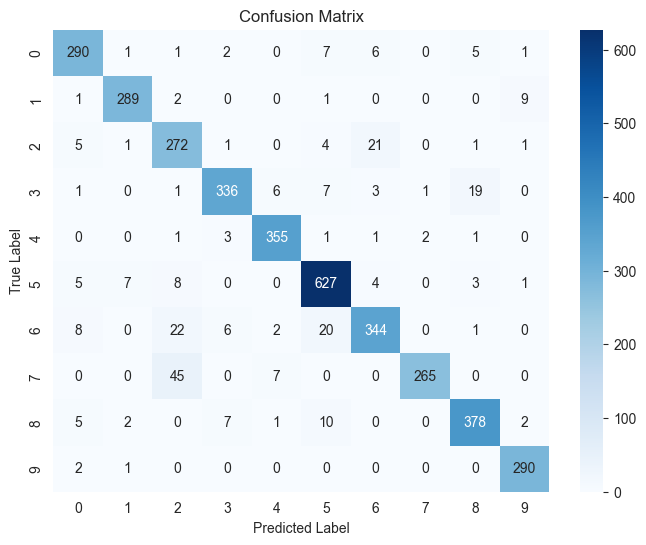

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Collect all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## save model for deployment

In [63]:
torch.save(model.state_dict(), "resnet_model_final.pth")
print("Model saved successfully!")


Model saved successfully!


#### web format

In [65]:
dummy_input = torch.randn(1, 3, 64, 64).to(device)
torch.onnx.export(model, dummy_input, "resnet_model.onnx", opset_version=11)
print("Model exported to ONNX format!")


Model exported to ONNX format!
